In [ ]:
# !pip install -r requirements.txt
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=06687785a2890f27fbbe4c08bd7206162ae44ee5dddba8cac0aabe535240bf6d
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


# 0. 라이브러리

# 1. Load Data

In [ ]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention
from sklearn.preprocessing import MinMaxScaler
from keras.utils.vis_utils import plot_model

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle
import random

In [ ]:
# from tensorflow.python.client import device_lib
# tf.config.list_physical_devices('GPU')

In [ ]:
# 혹시모르니 아래 코드 세개 다 쓰기
seed_num = 42
tf.random.set_seed(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data load
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)



In [ ]:
overall = train_set.shape[0] + valid_set.shape[0] + test_set.shape[0]
print('train:validation:test = %.4f:%.4f:%.4f'%((train_set.shape[0] / overall), (valid_set.shape[0] / overall), (test_set.shape[0] / overall)))

train:validation:test = 0.7000:0.1000:0.2000


In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,senti_score,NeMFRating,SBMFRating,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1633870,143756,31800,1.00,0.5719,3,3,4,0.00,0.00,0.00,0.00,16.67,0.00,0.00,33.33,0.00,16.67
3115182,272600,13746,1.00,0.0000,2,3,3,0.00,11.11,0.00,11.11,0.00,0.00,0.00,11.11,0.00,0.00
2383131,208589,23849,0.50,-0.2023,1,2,3,10.53,5.26,5.26,5.26,0.00,5.26,5.26,5.26,10.53,10.53
2079042,182422,14736,0.75,0.9666,3,3,5,5.04,4.20,9.24,8.40,6.72,7.56,5.04,4.20,14.29,13.45
651398,56973,53386,1.00,0.9260,3,3,5,0.00,27.27,0.00,4.55,18.18,0.00,13.64,40.91,0.00,27.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158490,13844,27705,1.00,0.7351,3,3,4,0.00,0.00,0.00,0.00,8.00,0.00,0.00,20.00,0.00,12.00
1734117,152410,28106,0.75,0.8750,3,3,5,0.00,3.77,0.00,3.77,3.77,0.00,3.77,11.32,3.77,5.66
1564450,137584,43164,1.00,0.6249,3,3,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33.33
212205,18521,42215,1.00,0.4588,3,3,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# import pandas as pd
# import numpy as np

# # Your initial data
# x = [0.1, 0.1, 0.2]
# y = [1, 2, 3]

# # Create the DataFrame
# x_df = pd.DataFrame(x, y, columns=['x'])

# # Custom normalization function
# def custom_norm(value):
#     min_value = np.min(x)
#     max_value = np.max(x)

#     if max_value - min_value == 0:  # Avoid division by zero
#         return value
#     else:
#         normalized_value = (value - min_value) / (max_value - min_value)
#         return normalized_value

# # Apply the custom normalization function to the 'x' column
# x_df['x'] = x_df['x'].apply(custom_norm)

# print(x_df['x'])

1    0.0
2    0.0
3    1.0
Name: x, dtype: float64


# 3.Model

In [ ]:
def conv_block(n_layers, latent_dims, names):
    ModuleList, DropoutList = [], []
    for i, _ in enumerate(range(n_layers)):
        ModuleList.append(Dense(latent_dims, activation='relu', name=f'{names}{i+1}'))
        latent_dims //= 2
    return ModuleList

In [ ]:
# def custom_norm(value):
#     min_value = np.min(x)
#     max_value = np.max(x)

#     if max_value - min_value == 0:  # Avoid division by zero
#         return value
#     else:
#         normalized_value = (value - min_value) / (max_value - min_value)
#         return normalized_value

In [ ]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    # GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    # Sentiment
    anger_input = Input(shape=(1,), dtype='int32', name='AngerInput')
    anger_dense = Dense(units=1, activation='relu', name='Dense_Anger')(anger_input)

    anticipation_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    anticipation_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anticipation_input)

    disgust_input = Input(shape=(1,), dtype='int32', name='DisgustInput')
    disgust_dense = Dense(units=1, activation='relu', name='Dense_Disgust')(disgust_input)

    fear_input = Input(shape=(1,), dtype='int32', name='FearInput')
    fear_dense = Dense(units=1, activation='relu', name='Dense_Fear')(fear_input)

    joy_input = Input(shape=(1,), dtype='int32', name='JoyInput')
    joy_dense = Dense(units=1, activation='relu', name='Dense_Joy')(joy_input)

    sadness_input = Input(shape=(1,), dtype='int32', name='SadnessInput')
    sadness_dense = Dense(units=1, activation='relu', name='Dense_Sadness')(sadness_input)

    surprise_input = Input(shape=(1,), dtype='int32', name='SurpriseInput')
    surprise_dense = Dense(units=1, activation='relu', name='Dense_Surprise')(surprise_input)

    trust_input = Input(shape=(1,), dtype='int32', name='TrustInput')
    trust_dense = Dense(units=1, activation='relu', name='Dense_Trust')(trust_input)

    # Sentiment = Concatenate(name='SentimentLayer')([anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])
    # Sentiment concatenation
    MLP_U_I_S = Concatenate(name='UserItemSentimentLayer')([MLP_U_I, anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, Sentiment])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1))+8)//2, 'UserItemSentimentMLP'):
        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input, anger_input, anticipation_input, disgust_input, fear_input, joy_input, sadness_input, surprise_input, trust_input], outputs=outputs)
    return model

In [ ]:
user_num = 281335
item_num = 59044

id_dims = 128# each 32 dims
total_layer_dims = 64 # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16

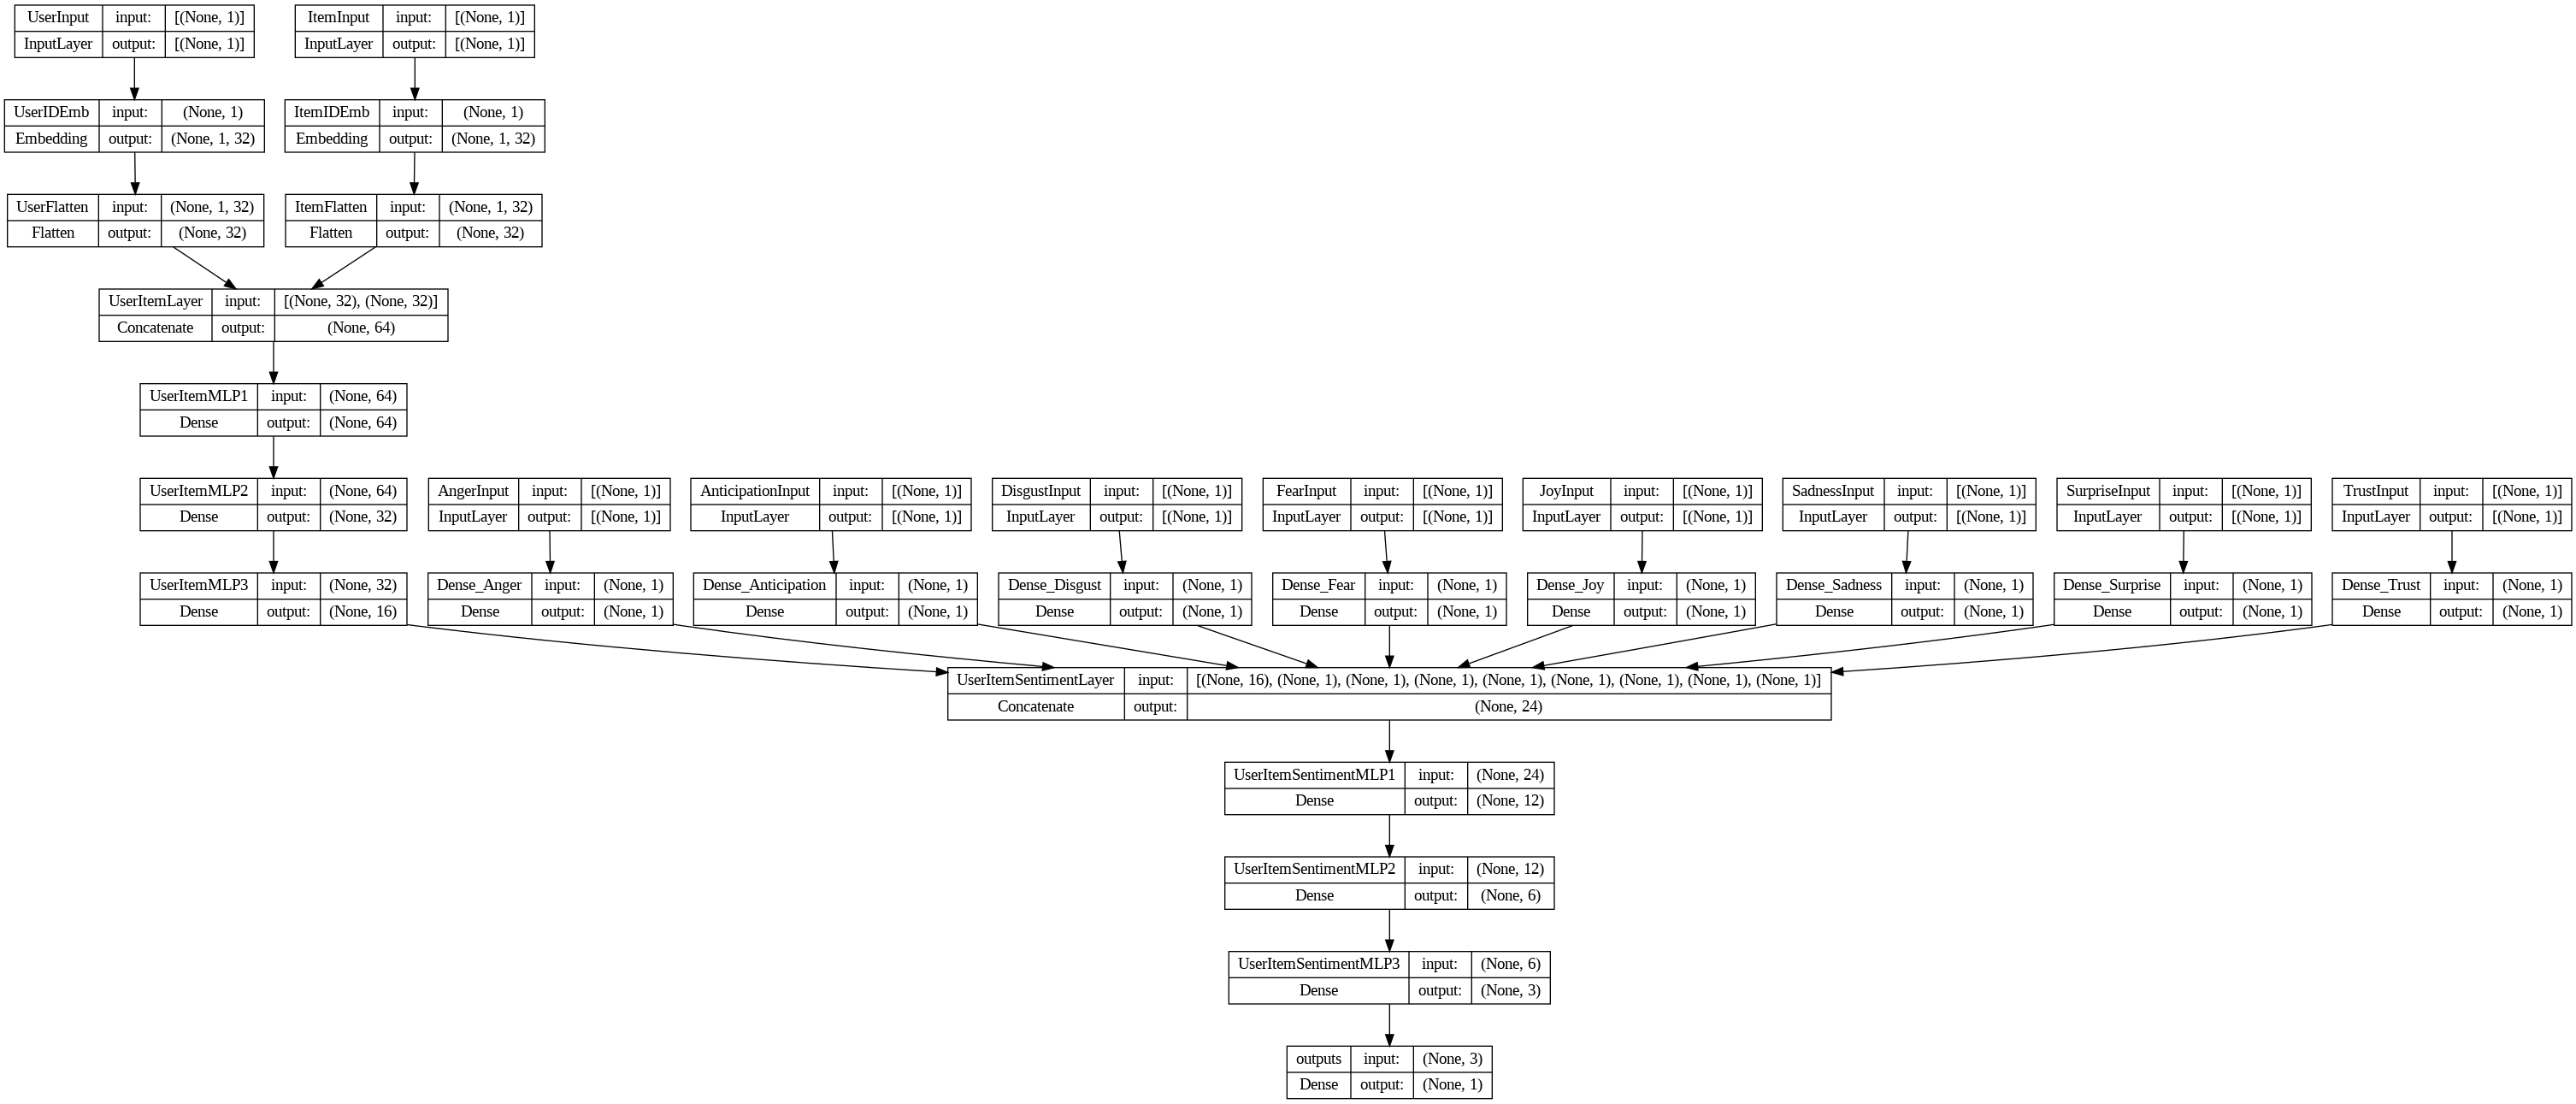

In [ ]:
model = ModelBuild(user_num = 281335, item_num = 59044, id_dims = 32, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)
plot_model(model, show_shapes=True, show_layer_names=True)

# Jihyeon_ex
- 모든 파라미터 돌려

- user_num = 281335
- item_num = 59044
--------
- id_dims = [256,128,64,32]
- total_layer_dims =  [128, 64, 32, 16] # ex. 128 -> 128 , 64, 32...
- total_n_layer = [3] # concat(64) -> 64-32-16
- lr = [0.0001, 0.0005, 0.001, 0.005]

In [ ]:
def model_run_param(id_dims, total_layer_dims,total_n_layer,lr):

    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)


    history = model.fit([train_set['userID'], train_set['movieID'], train_set['anger'], train_set['anticipation'], train_set['disgust'], train_set['fear'], train_set['joy'], train_set['sadness'], train_set['surprise'], train_set['trust']],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID'], valid_set['anger'], valid_set['anticipation'], valid_set['disgust'], valid_set['fear'], valid_set['joy'], valid_set['sadness'], valid_set['surprise'], valid_set['trust']],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID'], test_set['anger'], test_set['anticipation'], test_set['disgust'], test_set['fear'], test_set['joy'], test_set['sadness'], test_set['surprise'], test_set['trust']])

    # normalize 안해도 되겠단 생각이.. > 하는게 맞음
    prediction = 4 * norm(prediction) + 1

    # prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    layer_n = total_n_layer
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, layer_n, lr

### 실험1

In [ ]:
# 다시 시도...
user_num = 281335
item_num = 59044

id_dims = [128, 64, 32]
total_layer_dims =  [128, 64, 32] # ex. 128 -> 128 , 64, 32...
total_n_layer = [3] # concat(64) -> 64-32-16
lr = [0.001, 0.005]

In [ ]:
# # 다시 시도...
# user_num = 281335
# item_num = 59044

# id_dims = [32]
# total_layer_dims =  [16] # ex. 128 -> 128 , 64, 32...
# total_n_layer = [3] # concat(64) -> 64-32-16
# lr = [0.001]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_n_layer, param_lr = [], [], [], [], [],[]
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      for j in total_n_layer:
        MAE_temp, RMSE_temp, embedding_size, layer_dim, layer_n, learning_rate = model_run_param(a, b,j,i)

        MAE.append(MAE_temp)
        RMSE.append(RMSE_temp)
        param_embedding.append(embedding_size)
        param_layer_dim.append(layer_dim)
        param_lr.append(learning_rate)
        param_n_layer.append(layer_n)

Epoch 1/100
2199/2199 [==============================] - 49s 17ms/step - loss: 0.4307 - val_loss: 0.4047
Epoch 2/100
2199/2199 [==============================] - 20s 9ms/step - loss: 0.3767 - val_loss: 0.4033
Epoch 3/100
2199/2199 [==============================] - 19s 9ms/step - loss: 0.3475 - val_loss: 0.4118
Epoch 4/100
2199/2199 [==============================] - 22s 10ms/step - loss: 0.3199 - val_loss: 0.4386
Epoch 5/100
2199/2199 [==============================] - 19s 9ms/step - loss: 0.2918 - val_loss: 0.4680
Epoch 5: early stopping
20099/20099 [==============================] - 47s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.638
RMSE: 0.941
Epoch 1/100
2199/2199 [==============================] - 39s 15ms/step - loss: 0.4227 - val_loss: 0.4051
Epoch 2/100
2199/2199 [==============================] - 19s 9ms/step - loss: 0.3712 - val_loss: 0.4053
Epoch 3/100
2199/2199 [==============================] - 19s 9ms/step - loss: 0.3398 - val_loss: 0.4183
Epoch 4/100
2199/219

In [ ]:
jihyeon_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
jihyeon_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.638295,0.940666
1,128,128,0.005,0.688624,0.949289
2,128,64,0.001,0.636297,0.941614
3,128,64,0.005,0.639344,0.942287
4,128,32,0.001,0.645128,0.944871
5,128,32,0.005,0.636871,0.942595
6,64,128,0.001,0.639716,0.942701
7,64,128,0.005,0.636387,0.942016
8,64,64,0.001,0.638403,0.940660
9,64,64,0.005,0.642016,0.941475


In [ ]:
# 결과 저장
jihyeon_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000.final_proposed_result_norm.csv",index=False)


In [ ]:
final_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
final_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,256,128,0.005,0.637596,0.943973
1,256,128,0.001,0.637265,0.942388
2,256,64,0.005,0.642422,0.942918
3,256,64,0.001,0.666882,0.945685
4,256,32,0.005,0.639531,0.946660
5,256,32,0.001,0.642684,0.943980
6,256,16,0.005,0.665896,0.951367
7,256,16,0.001,0.677829,0.954994
8,128,128,0.005,0.681688,0.947467
9,128,128,0.001,0.638615,0.941766


In [ ]:
result_df2 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
result_df2

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,256,128,0.005,0.688066,0.949337
1,256,128,0.001,0.636142,0.942965
2,256,64,0.005,0.639206,0.942003
3,256,64,0.001,0.667860,0.946126
4,256,32,0.005,0.711894,1.029470
5,256,32,0.001,0.643921,0.944144
6,128,128,0.005,0.687126,0.949221
7,128,128,0.001,0.639790,0.942072
8,128,64,0.005,0.642600,0.942419
9,128,64,0.001,0.636650,0.940959


### 추가실험 - best param from 흠철
'''
embedding size=128
layer-n =3
Layer dim = 32
Learning rate = 0.001
'''

In [ ]:
# 다시 시도...
user_num = 281335
item_num = 59044

id_dims = [128]
total_layer_dims =  [32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
2199/2199 [==============================] - 37s 14ms/step - loss: 0.4279 - val_loss: 0.4054
Epoch 2/100
2199/2199 [==============================] - 20s 9ms/step - loss: 0.3782 - val_loss: 0.4038
Epoch 3/100
2199/2199 [==============================] - 19s 9ms/step - loss: 0.3544 - val_loss: 0.4131
Epoch 4/100
2199/2199 [==============================] - 20s 9ms/step - loss: 0.3333 - val_loss: 0.4308
Epoch 5/100
2199/2199 [==============================] - 19s 9ms/step - loss: 0.3132 - val_loss: 0.4519
Epoch 5: early stopping
20099/20099 [==============================] - 46s 2ms/step
embedding:128, layer_dim:32,lr:0.001
MAE: 0.645
RMSE: 0.944


In [ ]:
best_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
best_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,32,0.001,0.644547,0.943666


### 추가 실험

In [ ]:
# layer 수 조정 1,2,3

MAE, RMSE = [],[]
layer_n = []
for i in [1,2,3]:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(128, 64,i, 0.001)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      layer_n.append(i)

Epoch 1/100
2199/2199 [==============================] - 39s 15ms/step - loss: 0.4172 - val_loss: 0.3979
Epoch 2/100
2199/2199 [==============================] - 17s 8ms/step - loss: 0.3592 - val_loss: 0.3997
Epoch 3/100
2199/2199 [==============================] - 17s 8ms/step - loss: 0.3209 - val_loss: 0.4205
Epoch 4/100
2199/2199 [==============================] - 17s 8ms/step - loss: 0.2887 - val_loss: 0.4463
Epoch 4: early stopping
20099/20099 [==============================] - 44s 2ms/step
embedding:128, layer_dim:64,lr:0.001
MAE: 0.651
RMSE: 0.927
Epoch 1/100
2199/2199 [==============================] - 35s 14ms/step - loss: 0.4130 - val_loss: 0.3946
Epoch 2/100
2199/2199 [==============================] - 18s 8ms/step - loss: 0.3568 - val_loss: 0.3972
Epoch 3/100
2199/2199 [==============================] - 18s 8ms/step - loss: 0.3199 - val_loss: 0.4153
Epoch 4/100
2199/2199 [==============================] - 18s 8ms/step - loss: 0.2882 - val_loss: 0.4444
Epoch 4: early stoppin

In [ ]:
layer_df = pd.DataFrame(zip(layer_n, MAE, RMSE), columns=['n_layer','MAE','RMSE'])
layer_df

,n_layer,MAE,RMSE
0,1,0.650563,0.927032
1,2,0.647609,0.918843
2,3,0.675859,0.954205


### 실험2
- layer개수 2개로 고정하고,
- 위의 내용 토대로 파라미터 종류 좀 적게

In [ ]:
id_dims = [256, 128]
total_layer_dims =  [128, 64, 32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 2 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,2,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
2199/2199 [==============================] - 43s 17ms/step - loss: 0.4215 - val_loss: 0.3992
Epoch 2/100
2199/2199 [==============================] - 21s 10ms/step - loss: 0.3599 - val_loss: 0.4024
Epoch 3/100
2199/2199 [==============================] - 21s 10ms/step - loss: 0.3175 - val_loss: 0.4226
Epoch 4/100
2199/2199 [==============================] - 21s 10ms/step - loss: 0.2823 - val_loss: 0.4581
Epoch 4: early stopping
20099/20099 [==============================] - 45s 2ms/step
embedding:256, layer_dim:128,lr:0.001
MAE: 0.654
RMSE: 0.932
Epoch 1/100
2199/2199 [==============================] - 38s 15ms/step - loss: 0.4275 - val_loss: 0.4098
Epoch 2/100
2199/2199 [==============================] - 21s 10ms/step - loss: 0.3751 - val_loss: 0.4109
Epoch 3/100
2199/2199 [==============================] - 21s 10ms/step - loss: 0.3422 - val_loss: 0.4240
Epoch 4/100
2199/2199 [==============================] - 21s 10ms/step - loss: 0.3091 - val_loss: 0.4695
Epoch 4: early 

# n-core 실험
### sparsity 정리

- -----
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
- sparsity : 0.00018464025725
- -----
- 5core userID num :  281335
- 5core movieID num :  59044
- 5core rating num :   3215686
- sparsity : 0.000193586067903
- -----
- 10core userID num :  79067
- 10core movieID num :  29829
- 10core rating num :  1765142
- sparsity : 0.0007484205326408776
- -----
- 15core userID num :  33532
- 15core movieID num :  17250
- 15core rating num :  1098649
- sparsity : 0.0018993736461126469
- -----
- 20core userID num :  16007
- 20core movieID num :  9774
- 20core rating num :  685408
- sparsity : 0.004380935806310133

### 모델 먼저 가져오기

In [ ]:
def conv_block(n_layers, latent_dims, names):
    ModuleList, DropoutList = [], []
    for i, _ in enumerate(range(n_layers)):
        ModuleList.append(Dense(latent_dims, activation='relu', name=f'{names}{i+1}'))
        latent_dims //= 2
    return ModuleList

In [ ]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    # GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    # Sentiment
    anger_input = Input(shape=(1,), dtype='int32', name='AngerInput')
    anger_dense = Dense(units=1, activation='relu', name='Dense_Anger')(anger_input)

    anticipation_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    anticipation_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anticipation_input)

    disgust_input = Input(shape=(1,), dtype='int32', name='DisgustInput')
    disgust_dense = Dense(units=1, activation='relu', name='Dense_Disgust')(disgust_input)

    fear_input = Input(shape=(1,), dtype='int32', name='FearInput')
    fear_dense = Dense(units=1, activation='relu', name='Dense_Fear')(fear_input)

    joy_input = Input(shape=(1,), dtype='int32', name='JoyInput')
    joy_dense = Dense(units=1, activation='relu', name='Dense_Joy')(joy_input)

    sadness_input = Input(shape=(1,), dtype='int32', name='SadnessInput')
    sadness_dense = Dense(units=1, activation='relu', name='Dense_Sadness')(sadness_input)

    surprise_input = Input(shape=(1,), dtype='int32', name='SurpriseInput')
    surprise_dense = Dense(units=1, activation='relu', name='Dense_Surprise')(surprise_input)

    trust_input = Input(shape=(1,), dtype='int32', name='TrustInput')
    trust_dense = Dense(units=1, activation='relu', name='Dense_Trust')(trust_input)

    # Sentiment = Concatenate(name='SentimentLayer')([anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])
    # Sentiment concatenation
    MLP_U_I_S = Concatenate(name='UserItemSentimentLayer')([MLP_U_I, anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, Sentiment])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1))+8)//2, 'UserItemSentimentMLP'):
        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input, anger_input, anticipation_input, disgust_input, fear_input, joy_input, sadness_input, surprise_input, trust_input], outputs=outputs)
    return model

In [ ]:
def model_run_param(id_dims, total_layer_dims,total_n_layer,lr):

    # param_embedding, param_layer_dim, param_lr = [],[],[]
    # MAE, RMSE = [], []
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)
    # model.summary()

    history = model.fit([train_set['userID'], train_set['movieID'], train_set['anger'], train_set['anticipation'], train_set['disgust'], train_set['fear'], train_set['joy'], train_set['sadness'], train_set['surprise'], train_set['trust']],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID'], valid_set['anger'], valid_set['anticipation'], valid_set['disgust'], valid_set['fear'], valid_set['joy'], valid_set['sadness'], valid_set['surprise'], valid_set['trust']],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID'], test_set['anger'], test_set['anticipation'], test_set['disgust'], test_set['fear'], test_set['joy'], test_set['sadness'], test_set['surprise'], test_set['trust']])

    # normalize 안해도 되겠단 생각이..
    prediction = 4 * norm(prediction) + 1
    # prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    # MAE.append(MAE_temp)
    # RMSE.append(RMSE_temp)
    # param_embedding.append(embedding_size)
    # param_layer_dim.append(layer_dim)
    # param_lr.append(lr)

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, lr

### 10-core 실험
- 10core userID num :  79067
- 10core movieID num :  29829
- 10core rating num :  1765142
- sparsity : 0.0007484205326408776

In [ ]:
# 10-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,senti_score,NeMFRating,SBMFRating,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
235661,10446,23475,1.00,0.5719,3,3,4,0.00,33.33,0.00,0.00,33.33,0.00,0.00,33.33,0.00,33.33
113570,5000,20517,1.00,0.9878,3,3,5,0.00,18.87,0.00,11.32,7.55,3.77,5.66,9.43,3.77,11.32
1247521,55924,12136,0.25,0.5267,3,1,4,6.90,12.07,5.17,1.72,10.34,0.00,8.62,15.52,15.52,22.41
129057,5698,15576,0.00,0.8642,3,1,5,1.75,10.53,3.51,1.75,7.02,0.00,1.75,12.28,7.02,14.04
951739,42826,11307,0.75,0.7717,3,3,5,0.00,7.69,0.00,0.00,23.08,0.00,7.69,7.69,0.00,30.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758873,34081,15219,0.00,-0.9754,1,1,1,4.82,3.51,4.39,2.63,3.95,6.58,3.07,4.39,13.16,11.40
1600791,71690,2795,0.75,0.9938,3,3,5,2.40,5.11,1.20,3.60,5.71,5.11,2.40,8.11,8.11,14.11
1473430,65957,15443,1.00,0.9750,3,3,5,1.52,10.61,3.03,1.52,12.12,1.52,3.03,12.12,3.03,27.27
970010,43558,21125,0.75,0.9652,3,3,5,0.00,13.33,0.00,0.00,16.67,0.00,6.67,23.33,0.00,16.67


In [ ]:
'''
- 10core userID num :  79067
- 10core movieID num :  29829
- 10core rating num :  1765142
- sparsity : 0.0007484205326408776
'''

# 다시 시도...
user_num = 79067
item_num = 29829

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
1207/1207 [==============================] - 35s 24ms/step - loss: 0.4426 - val_loss: 0.4087
Epoch 2/100
1207/1207 [==============================] - 9s 8ms/step - loss: 0.3918 - val_loss: 0.4048
Epoch 3/100
1207/1207 [==============================] - 9s 8ms/step - loss: 0.3743 - val_loss: 0.4103
Epoch 4/100
1207/1207 [==============================] - 10s 8ms/step - loss: 0.3549 - val_loss: 0.4201
Epoch 5/100
1207/1207 [==============================] - 11s 9ms/step - loss: 0.3315 - val_loss: 0.4397
Epoch 5: early stopping
11033/11033 [==============================] - 26s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.644
RMSE: 0.917
Epoch 1/100
1207/1207 [==============================] - 30s 20ms/step - loss: 0.4306 - val_loss: 0.4087
Epoch 2/100
1207/1207 [==============================] - 10s 8ms/step - loss: 0.3906 - val_loss: 0.4055
Epoch 3/100
1207/1207 [==============================] - 9s 8ms/step - loss: 0.3709 - val_loss: 0.4130
Epoch 4/100
1207/1207 [=

In [ ]:
core10_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core10_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.644249,0.917331
1,128,128,0.005,0.635453,0.917334
2,128,64,0.001,0.642068,0.917217
3,128,64,0.005,0.624950,0.919456
4,128,32,0.001,0.648229,0.921944
5,128,32,0.005,0.668052,0.949174
6,64,128,0.001,0.643634,0.917508
7,64,128,0.005,0.631871,0.917906
8,64,64,0.001,0.645966,0.918371
9,64,64,0.005,0.627102,0.916698


In [ ]:
core10_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000-extra1.final_proposed_10-core_result_norm.csv",index=False)


In [ ]:
core10_df2 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core10_df2

In [ ]:
core10_df2.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-extra1.NEW_proposed_10-core_result_NEWnotnorm.csv",index=False)


### 15-core 실험
- 15core userID num :  33532
- 15core movieID num :  17250
- 15core rating num :  1098649
- sparsity : 0.0018993736461126469

In [ ]:
# 15-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,senti_score,NeMFRating,SBMFRating,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
69164,2082,9868,1.00,0.9325,3,3,5,7.94,1.59,1.59,3.17,3.17,1.59,0.00,4.76,6.35,14.29
984679,30052,7095,0.75,-0.5423,1,3,2,4.92,8.20,3.28,8.20,3.28,3.28,4.92,4.92,11.48,9.84
703084,21545,5855,0.75,0.9325,3,3,5,2.48,11.57,4.13,5.79,9.92,3.31,5.79,9.92,7.44,16.53
959192,29309,14605,0.75,0.8744,3,3,5,3.77,7.55,0.00,0.00,1.89,1.89,0.00,13.21,1.89,16.98
838122,25602,3903,0.00,-0.6715,1,1,2,1.04,2.78,2.08,1.04,3.82,2.08,1.74,4.86,4.17,9.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230308,6959,15644,0.50,0.8979,3,2,5,0.00,20.00,6.67,0.00,20.00,0.00,6.67,13.33,6.67,20.00
230598,6968,16914,1.00,0.9812,3,3,5,0.00,8.11,0.00,2.70,16.22,0.00,2.70,10.81,0.00,27.03
743327,22771,9746,1.00,0.0000,2,3,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
950998,29041,12255,1.00,0.8020,3,3,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.33,8.33,16.67


In [ ]:
'''
- 15core userID num :  33532
- 15core movieID num :  17250
- 15core rating num :  1098649
- sparsity : 0.0018993736461126469
'''

# 다시 시도...
user_num = 33532
item_num = 17250

id_dims = [128,64, 32]
total_layer_dims =  [128,64, 32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
752/752 [==============================] - 31s 33ms/step - loss: 0.4559 - val_loss: 0.4157
Epoch 2/100
752/752 [==============================] - 6s 8ms/step - loss: 0.4016 - val_loss: 0.4118
Epoch 3/100
752/752 [==============================] - 7s 9ms/step - loss: 0.3904 - val_loss: 0.4116
Epoch 4/100
752/752 [==============================] - 7s 9ms/step - loss: 0.3778 - val_loss: 0.4165
Epoch 5/100
752/752 [==============================] - 7s 9ms/step - loss: 0.3621 - val_loss: 0.4271
Epoch 6/100
752/752 [==============================] - 6s 8ms/step - loss: 0.3427 - val_loss: 0.4505
Epoch 6: early stopping
6867/6867 [==============================] - 16s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.638
RMSE: 0.903
Epoch 1/100
752/752 [==============================] - 25s 26ms/step - loss: 0.4371 - val_loss: 0.4183
Epoch 2/100
752/752 [==============================] - 7s 9ms/step - loss: 0.4001 - val_loss: 0.4111
Epoch 3/100
752/752 [========================

In [ ]:
core15_df= pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core15_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.638075,0.902908
1,128,128,0.005,0.629230,0.902936
2,128,64,0.001,0.632592,0.904597
3,128,64,0.005,0.633356,0.902194
4,128,32,0.001,0.635294,0.904814
5,128,32,0.005,0.659124,0.924405
6,64,128,0.001,0.627765,0.903505
7,64,128,0.005,0.627884,0.902725
8,64,64,0.001,0.633522,0.905499
9,64,64,0.005,0.631169,0.901533


In [ ]:
core15_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000-extra1.final_proposed_15-core_result_norm.csv",index=False)


In [ ]:
core15_df2 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core15_df2

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,256,32,0.001,0.634314,0.905524
1,256,32,0.005,0.639325,0.911080
2,128,32,0.001,0.634740,0.904379
3,128,32,0.005,0.634235,0.909507
4,64,32,0.001,0.634915,0.904145
5,64,32,0.005,0.633108,0.906519


In [ ]:
core15_df2.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-extra1.NEW_proposed_15-core_result_NEWnotnorm.csv",index=False)


### 20-core 실험
- 20core userID num :  16007
- 20core movieID num :  9774
- 20core rating num :  685408
- sparsity : 0.004380935806310133

In [ ]:
# 20-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,senti_score,NeMFRating,SBMFRating,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
623828,14585,3264,0.50,0.7320,3,2,4,4.12,7.22,2.06,4.12,7.22,4.12,3.09,9.28,6.19,12.37
419497,9806,3681,0.25,0.9962,3,1,5,1.72,3.94,0.99,2.71,3.69,2.22,2.71,7.88,3.94,11.82
13487,314,9579,1.00,0.9042,3,3,5,0.00,4.55,0.00,4.55,0.00,0.00,0.00,0.00,0.00,0.00
235295,5439,1542,1.00,0.0000,2,3,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.00
598965,14017,8275,1.00,0.8316,3,3,5,0.00,16.67,0.00,0.00,16.67,0.00,0.00,16.67,0.00,16.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115627,2596,8750,0.50,0.6486,3,2,4,0.00,30.77,0.00,15.38,15.38,7.69,0.00,7.69,15.38,23.08
84209,1909,9568,0.50,0.6908,3,2,4,0.00,18.18,0.00,9.09,9.09,0.00,0.00,9.09,0.00,9.09
291134,6725,6932,0.50,0.5859,3,2,4,8.33,25.00,8.33,16.67,16.67,16.67,16.67,25.00,16.67,25.00
493488,11540,8337,1.00,0.4404,3,3,4,0.00,50.00,0.00,0.00,50.00,0.00,50.00,50.00,0.00,50.00


In [ ]:
'''
- 20core userID num :  16007
- 20core movieID num :  9774
- 20core rating num :  685408
- sparsity : 0.004380935806310133
'''

# 다시 시도...
user_num = 16007
item_num = 9774

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
469/469 [==============================] - 29s 50ms/step - loss: 0.4807 - val_loss: 0.4267
Epoch 2/100
469/469 [==============================] - 6s 12ms/step - loss: 0.4162 - val_loss: 0.4220
Epoch 3/100
469/469 [==============================] - 4s 9ms/step - loss: 0.4076 - val_loss: 0.4213
Epoch 4/100
469/469 [==============================] - 4s 9ms/step - loss: 0.3999 - val_loss: 0.4229
Epoch 5/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3903 - val_loss: 0.4288
Epoch 6/100
469/469 [==============================] - 5s 10ms/step - loss: 0.3760 - val_loss: 0.4368
Epoch 6: early stopping
4284/4284 [==============================] - 10s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.627
RMSE: 0.897
Epoch 1/100
469/469 [==============================] - 23s 38ms/step - loss: 0.4531 - val_loss: 0.4273
Epoch 2/100
469/469 [==============================] - 5s 11ms/step - loss: 0.4165 - val_loss: 0.4228
Epoch 3/100
469/469 [====================

In [ ]:
core20_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core20_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.626835,0.896853
1,128,128,0.005,0.654225,0.902811
2,128,64,0.001,0.626652,0.896630
3,128,64,0.005,0.653069,0.906673
4,128,32,0.001,0.631487,0.899647
5,128,32,0.005,0.641750,0.900815
6,64,128,0.001,0.628655,0.897730
7,64,128,0.005,0.656752,0.903005
8,64,64,0.001,0.626426,0.897391
9,64,64,0.005,0.655538,0.905199


In [ ]:
core20_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000-extra1.final_proposed_20-core_result_norm.csv",index=False)


### 2-core 실험
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
- sparsity : 0.00018464025725

In [ ]:
# 20-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,SBMFRating,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1601217,258079,33219,0.25,0.9409,5,3.14,2.52,2.52,3.14,3.14,2.52,1.26,3.77,8.81,13.21
2109928,267784,20408,0.50,-0.0314,3,16.67,8.33,0.00,16.67,8.33,8.33,8.33,8.33,25.00,8.33
1044096,213376,18340,1.00,0.6249,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
173120,61529,1914,1.00,0.3612,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2097197,228461,42684,0.50,0.7003,4,7.69,15.38,7.69,15.38,7.69,23.08,0.00,7.69,23.08,7.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15501,8927,132,1.00,0.4404,4,0.00,50.00,0.00,0.00,50.00,0.00,50.00,50.00,0.00,50.00
1977038,178288,40882,1.00,-0.8187,1,3.85,5.77,7.69,7.69,3.85,3.85,7.69,3.85,5.77,9.62
1438382,75224,29409,1.00,0.8555,5,0.00,10.00,0.00,5.00,10.00,0.00,5.00,15.00,0.00,20.00
2593677,238021,51001,1.00,0.4201,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
'''
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
- sparsity : 0.00018464025725
'''
# 다시 시도...
user_num = 297514
item_num = 60085

id_dims = [128, 64, 32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

In [ ]:
core2_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core2_df

In [ ]:
core2_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000-extra1.final_proposed_2-core_result_norm.csv",index=False)
